## 🧠💡 Intelligent Systems  for Smart Health 👨‍⚕👩‍⚕️🔬🌡️


# Finding hyperparameters and understanding models

In the last weeks we trained linear models, decision tree and a random forest. In all those cases we were manually adjusting hyperparameters. The more complex our models get... the more inefficient this procedure becomes. So we will look at **grid search** and **random search** as two common techniques for (still fairly simple) hyperparameter searches.

In the second part of this session we will then ask the question of how to make sense of the predictions we get from such an optimized machine learning model. Why does one patient get a good prognosis, and another one a bad one?
In this context, we will look at the **feature importance** (for a random forest model) and and **SHAP**, a newer technique to interpret model predictions.

We will (again) work with actual medical data in this notebook, namely the NHANES I epidemiology dataset (for a detailed description of this dataset you can check the [CDC Website](https://wwwn.cdc.gov/nchs/nhanes/nhefs/default.aspx/)).


<a name='import'></a>
## Import Packages

We'll first import all the common packages that we need for this assignment. 

- `shap` is a library that explains predictions made by machine learning models.
- `sklearn` is one of the most popular machine learning libraries.
- `itertools` allows us to conveniently manipulate iterable objects such as lists.
- `pydotplus` is used together with `IPython.display.Image` to visualize graph structures such as decision trees.
- `numpy` is a fundamental package for scientific computing in Python.
- `pandas` is what we'll use to manipulate our data.
- `seaborn` is a plotting library which has some convenient functions for visualizing missing data.
- `matplotlib` is a plotting library.

In [1]:
#!pip install pydotplus
#!pip install lifelines
#!pip install shap

In [2]:
import os
import shap
import sklearn
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image 

from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

<a name='1'></a>
## 1. The Dataset
### Load and explore the data!

In virtually all cases, we would first want to get an intuition on the data itself. Things like: What is in the data? How much data is there? Are there things missing? What might cause problems? Do we understand the type of data/features?

With **pandas**, we usually can explore some key properties very rapidly, for instance with commands like

- `data.head()`
- `data.describe()`
- `data.info()`

### Some weird conventions:
For some reason it became standard in the machine learning world to name the actual data `X` and the labels `y`. Even though I consider this a rather poor choice both from a math and from a code best practice point of view, we will stick to this in this notebook.

In [3]:
path_data = "data"

X = pd.read_csv(os.path.join(path_data, "NHANESI_subset_X.csv"))
y = pd.read_csv(os.path.join(path_data, "NHANESI_subset_y.csv"))

X = X.drop('Unnamed: 0', axis=1)
y = y.drop('Unnamed: 0', axis=1)

X.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0


In [4]:
data = X.copy()
data["time"] = y
data = data.dropna(axis="rows")
data.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,time
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0,15.274658
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0,11.586073
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0,8.149087
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0,-21.094292
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0,-0.000000


In [5]:
threshold = 10  # we focus on >10 year risk

data["death"] = np.ones(len(data))

# remove all people which haven't died within the study
data.loc[data["time"] < 0, "death"] = 0

# remove data which we can (and should) not use for predicting >10 year risk
mask = (data["time"] > 0) | (data["time"] <= -threshold)
data = data[mask]

# Create data/label split --> X, y
X = data.drop(["death", "time"], axis='columns')
y = (data.time < threshold) & (data.time > 0)  # died within 0 and threshold years

In [6]:
X.shape, y.shape

((8233, 18), (8233,))

In [7]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.15,
                                                random_state=10)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev,
                                                  test_size=0.18, random_state=10)

In [9]:
X_train.shape,X_test.shape, X_val.shape

((5738, 18), (1235, 18), (1260, 18))

In [10]:
# in this context we will also use the c-index to evaluate our models
import lifelines

def cindex(y_true, scores):
    return lifelines.utils.concordance_index(y_true, scores)

<a name='2'></a>
## 2. Random Forests

As we saw last time, a single decision tree is prone to overfitting. To solve this problem, you can try **random forests**, which combine predictions from many different trees to create a robust classifier. 

As before, we will use scikit-learn to build a random forest for the data. We will use the default hyperparameters.

Using Scikit-Learn we can train such a model using the `RandomForestClassifier()` class and, again, the `fit()` method to train the model.

In [11]:
forest = RandomForestClassifier(n_estimators=40,random_state=10, max_depth=4)
forest.fit(X_train,y_train)

# please train a random forest model using the RandomForestClassifier() class
# start with 10 trees --> n_estimators=10


RandomForestClassifier(max_depth=4, n_estimators=40, random_state=10)

In [12]:
y_train_preds = forest.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")

y_val_preds = forest.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {cindex(y_val.values, y_val_preds)}")


Train C-Index: 0.8718332950850315
Val C-Index: 0.8431023607857272


Training a random forest with the default hyperparameters results in a model that has better predictive performance than individual decision trees as in the previous section, but this model is overfitting.

We therefore need to tune (or optimize) the hyperparameters, to find a model that both has good predictive performance and minimizes overfitting.

The hyperparameters we choose to adjust will be:

- `n_estimators`: the number of trees used in the forest.
- `max_depth`: the maximum depth of each tree.
- `min_samples_leaf`: the minimum number (if `int`) or proportion (if `float`) of samples in a leaf.


<a name='ex1'></a>
### Exercise 1: try to find a set of better hyperparameters!


In [13]:
# train some models using different hyperparameters

In [14]:
y_train_preds = forest.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")

y_val_preds = forest.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {cindex(y_val.values, y_val_preds)}")


Train C-Index: 0.8718332950850315
Val C-Index: 0.8431023607857272


<a name='3'></a>
## 3.Systematic search for hyperparameters: grid search

The approach we implement to tune the hyperparameters is known as a grid search:

- We define a set of possible values for each of the target hyperparameters.

- A model is trained and evaluated for every possible combination of hyperparameters.

- The best performing set of hyperparameters is returned.

The cell below implements a hyperparameter grid search, using the C-Index to evaluate each tested model.

In [15]:
from sklearn.model_selection import GridSearchCV



In [16]:
parameters ={"max_depth":[4,8,12,20,30],
             "min_samples_leaf":[2,5,10],
             "n_estimators":[10,20,30,40,100]
             }
forest = RandomForestClassifier()
grid_search = GridSearchCV(forest,parameters,verbose=2)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] END ...max_depth=4, min_samples_leaf=2, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=2, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=2, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=2, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=2, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=2, n_estimators=30; total time=   0.1s
[CV] END ...max_depth=4, min_samples_leaf=2, n_

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 8, 12, 20, 30],
                         'min_samples_leaf': [2, 5, 10],
                         'n_estimators': [10, 20, 30, 40, 100]},
             verbose=2)

In [17]:
grid_search.best_params_


{'max_depth': 12, 'min_samples_leaf': 2, 'n_estimators': 30}

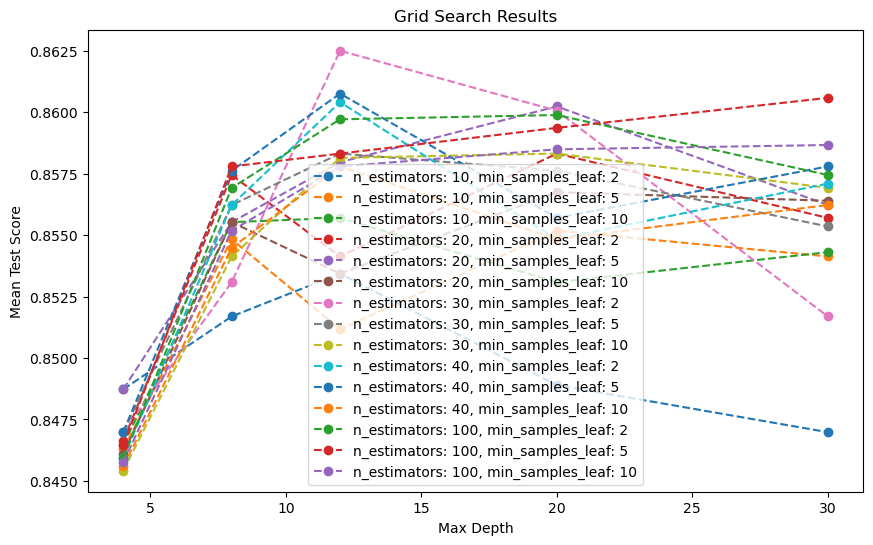

In [18]:
# Collect grid search results
cv_results = grid_search.cv_results_
mean_test_scores = cv_results['mean_test_score']
params = cv_results['params']

# Prepare data for plotting
scores_array = np.array(mean_test_scores).reshape(len(parameters['max_depth']),
                                                  len(parameters['min_samples_leaf']),
                                                  len(parameters['n_estimators']))

# Create a line plot for each n_estimators
fig, ax = plt.subplots(figsize=(10, 6))

for k, n_estimators in enumerate(parameters['n_estimators']):
    scores_for_n_estimators = scores_array[:, :, k].T
    for i, min_samples_leaf in enumerate(parameters['min_samples_leaf']):
        ax.plot(parameters['max_depth'], scores_for_n_estimators[i],
                marker='o', linestyle='--', label=f'n_estimators: {n_estimators}, min_samples_leaf: {min_samples_leaf}')

ax.set_title('Grid Search Results')
ax.set_xlabel('Max Depth')
ax.set_ylabel('Mean Test Score')
ax.legend(loc='best')

plt.show()

In [19]:
y_train_preds = grid_search.best_estimator_.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")

y_val_preds = grid_search.best_estimator_.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {cindex(y_val.values, y_val_preds)}")

y_test_preds = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
print(f"test C-Index: {cindex(y_test.values, y_test_preds)}")

Train C-Index: 0.9950629616400378
Val C-Index: 0.836131635329689
test C-Index: 0.8306244406593724


## Random Search
A common alternative to the simple grid search is a more randomized search. The version that is implemented in Scikit-learn is a bit of a hybrid. It can be seen as a randomized search within a grid.

In [20]:
from sklearn.model_selection import RandomizedSearchCV


parameters ={"max_depth":[1,2,3,6,8,10],
             "min_samples_leaf":[1,3,5,8,9,12],
             "n_estimators":[10,20,30,50,80,100]
             }
forest = RandomForestClassifier()
random_search = RandomizedSearchCV(forest,parameters,n_iter=20, verbose=2)
random_search.fit(X_train,y_train)



Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...max_depth=3, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=3, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=3, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=3, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=3, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=6, min_samples_leaf=3, n_estimators=30; total time=   0.1s
[CV] END ...max_depth=6, min_samples_leaf=3, n_

KeyboardInterrupt: 

In [ ]:
random_search.best_params_

{'n_estimators': 20, 'min_samples_leaf': 3, 'max_depth': 8}

In [ ]:
random_search.cv_results_["params"]

[{'n_estimators': 80, 'min_samples_leaf': 8, 'max_depth': 3},
 {'n_estimators': 20, 'min_samples_leaf': 3, 'max_depth': 8},
 {'n_estimators': 100, 'min_samples_leaf': 5, 'max_depth': 3},
 {'n_estimators': 30, 'min_samples_leaf': 3, 'max_depth': 8},
 {'n_estimators': 30, 'min_samples_leaf': 3, 'max_depth': 1},
 {'n_estimators': 30, 'min_samples_leaf': 8, 'max_depth': 1},
 {'n_estimators': 10, 'min_samples_leaf': 8, 'max_depth': 2},
 {'n_estimators': 100, 'min_samples_leaf': 8, 'max_depth': 6},
 {'n_estimators': 80, 'min_samples_leaf': 9, 'max_depth': 2},
 {'n_estimators': 10, 'min_samples_leaf': 3, 'max_depth': 1},
 {'n_estimators': 30, 'min_samples_leaf': 3, 'max_depth': 3},
 {'n_estimators': 80, 'min_samples_leaf': 1, 'max_depth': 1},
 {'n_estimators': 100, 'min_samples_leaf': 9, 'max_depth': 2},
 {'n_estimators': 30, 'min_samples_leaf': 3, 'max_depth': 10},
 {'n_estimators': 80, 'min_samples_leaf': 3, 'max_depth': 10},
 {'n_estimators': 20, 'min_samples_leaf': 12, 'max_depth': 3},
 {

In [ ]:
model = random_search.best_estimator_
y_train_preds = model.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")

y_val_preds = model.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {cindex(y_val.values, y_val_preds)}")

y_test_preds = model.predict_proba(X_test)[:, 1]
print(f"test C-Index: {cindex(y_test.values, y_test_preds)}")

Train C-Index: 0.9422962676443426
Val C-Index: 0.8413878376484252
test C-Index: 0.8308169019505952


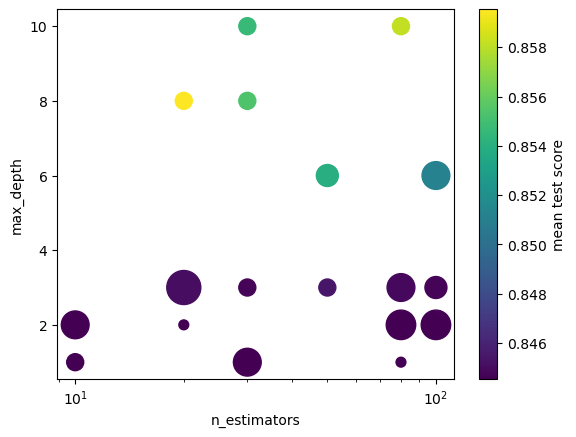

In [ ]:
xlabel = "n_estimators"
ylabel = "max_depth"
zlabel = "min_samples_leaf"
x = []
y = []
z = []
for param in random_search.cv_results_["params"]:
    x.append(param[xlabel])
    y.append(param[ylabel])
    z.append(param[zlabel])

plt.scatter(x, y, s=50*np.array(z),
            c=random_search.cv_results_["mean_test_score"])
plt.colorbar(label="mean test score")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xscale("log")

In [ ]:
# take the "best" model
model = random_search.best_estimator_

### just to all be on the same page, lets train one last model!

In [ ]:
model = RandomForestClassifier(n_estimators=100,
                               max_depth=7,
                               min_samples_leaf=5,
                               random_state=10)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=5, random_state=10)

<a name='7'></a>
## 7. Explainability
Using a random forest has improved results, but we've lost some of the natural interpretability of trees. In this section we'll try to explain the predictions using slightly more sophisticated techniques. 

But first, we will simply look at the **feature importance**:

In [ ]:
model.feature_importances_  # what does this mean?

array([0.33746271, 0.02749277, 0.04489455, 0.00154713, 0.02917415,
       0.06838595, 0.03650901, 0.0313369 , 0.02424854, 0.02793827,
       0.02072798, 0.06068511, 0.06369941, 0.03389428, 0.02729929,
       0.03551547, 0.04307275, 0.08611574])

In [ ]:
feature_importance = pd.DataFrame(model.feature_importances_,columns=["feature_importance"], index=X_train.columns)

In [ ]:
feature_importance

,feature_importance
Age,0.337463
Diastolic BP,0.027493
Poverty index,0.044895
Race,0.001547
Red blood cells,0.029174
Sedimentation rate,0.068386
Serum Albumin,0.036509
Serum Cholesterol,0.031337
Serum Iron,0.024249
Serum Magnesium,0.027938


In [ ]:
feature_importance.sort_values("feature_importance", ascending=False)

,feature_importance
Age,0.337463
Pulse pressure,0.086116
Sedimentation rate,0.068386
Systolic BP,0.063699
Sex,0.060685
Poverty index,0.044895
BMI,0.043073
Serum Albumin,0.036509
White blood cells,0.035515
TIBC,0.033894


<a name='shap'></a>
## Better than only feature importance: SHAP

Looking at the feature importance was interesting, and tells us a bit more about the model.
But since recently, we can do much better!

Now we will apply **SHAP (SHapley Additive exPlanations)**, a cutting edge method that explains predictions made by black-box machine learning models (i.e. models which are too complex to be understandable by humans as is).

> Given a prediction made by a machine learning model, SHAP values explain the prediction by quantifying the additive importance of each feature to the prediction. SHAP values have their roots in cooperative game theory, where Shapley values are used to quantify the contribution of each player to the game.
> 
> Although it is computationally expensive to compute SHAP values for general black-box models, in the case of trees and forests there exists a fast polynomial-time algorithm. For more details, see the [TreeShap paper](https://arxiv.org/pdf/1802.03888.pdf).

We'll use the [shap library](https://github.com/slundberg/shap) to do this for our random forest model. Run the next cell to output the most at risk individuals in the test set according to our model.

In [ ]:
proba_death = model.predict_proba(X_test)[:,1]

In [ ]:
X_test_risk = X_test.copy(deep=True)
X_test_risk["predicted_risk"] = proba_death
X_test_risk = X_test_risk.sort_values("predicted_risk", ascending=False)
X_test_risk.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,predicted_risk
5493,67.0,80.0,30.0,1.0,77.7,59.0,3.4,231.0,36.0,1.40,6.3,1.0,170.0,202.0,17.8,8.4,17.029470,90.0,0.654311
8628,73.0,70.0,71.0,2.0,40.1,60.0,3.8,187.0,58.0,1.97,7.0,2.0,130.0,220.0,26.4,10.9,16.998084,60.0,0.626556
2036,74.0,96.0,210.0,1.0,42.1,51.0,4.2,175.0,93.0,1.70,7.5,1.0,206.0,346.0,26.9,7.0,23.667245,110.0,0.623782
2469,70.0,70.0,54.0,1.0,44.5,24.0,4.3,205.0,206.0,1.78,7.9,1.0,190.0,343.0,60.1,7.7,17.595799,120.0,0.598181
7256,74.0,104.0,253.0,1.0,55.3,8.0,4.5,267.0,74.0,1.79,7.6,1.0,210.0,478.0,15.5,5.1,27.020329,106.0,0.593765


We can use SHAP values to try and understand the model output on specific individuals using force plots. Run the cell below to see a force plot on the riskiest individual. 

In [ ]:
i = 67
patientID = X_test_risk.index[i]
print(patientID)
print(X_test.loc[patientID, :], "\n")
print(f"Our model predicts: {model.predict(X_test.loc[[patientID]])}")

5934
Age                    65.00000
Diastolic BP          118.00000
Poverty index          51.00000
Race                    2.00000
Red blood cells        77.70000
Sedimentation rate     39.00000
Serum Albumin           4.30000
Serum Cholesterol     234.00000
Serum Iron             83.00000
Serum Magnesium         1.63000
Serum Protein           7.10000
Sex                     2.00000
Systolic BP           230.00000
TIBC                  334.00000
TS                     24.90000
White blood cells      12.60000
BMI                    35.42454
Pulse pressure        112.00000
Name: 5934, dtype: float64 

Our model predicts: [False]


### Why this prediction?

In [ ]:
explainer = shap.TreeExplainer(model)


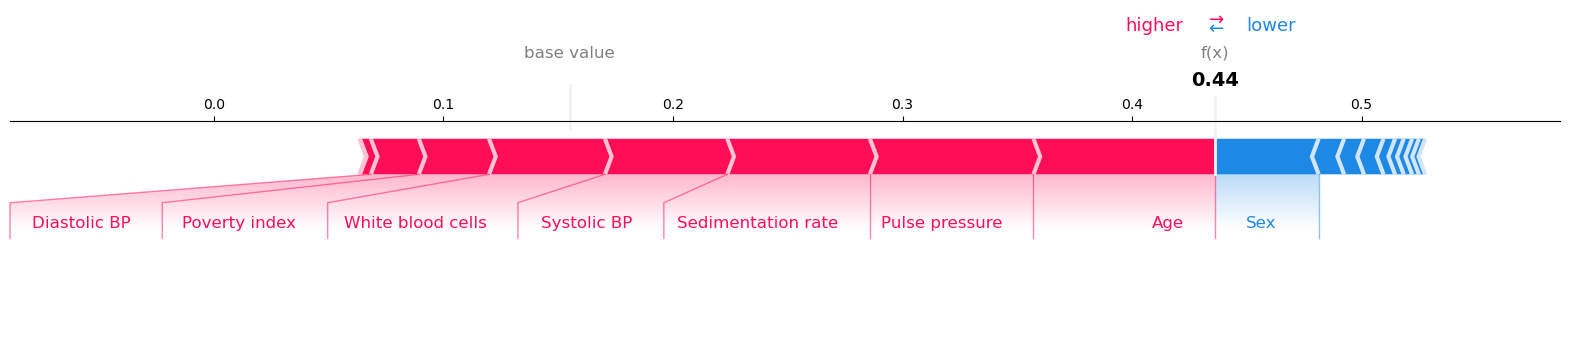

In [ ]:
shap_value=explainer.shap_values(X_test.loc[patientID])[1]
shap.force_plot(explainer.expected_value[1],shap_value, feature_names=X_test.columns, matplotlib=True)

In [ ]:
#Für alle Personen
shap_values = explainer.shap_values(X_test)[1]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


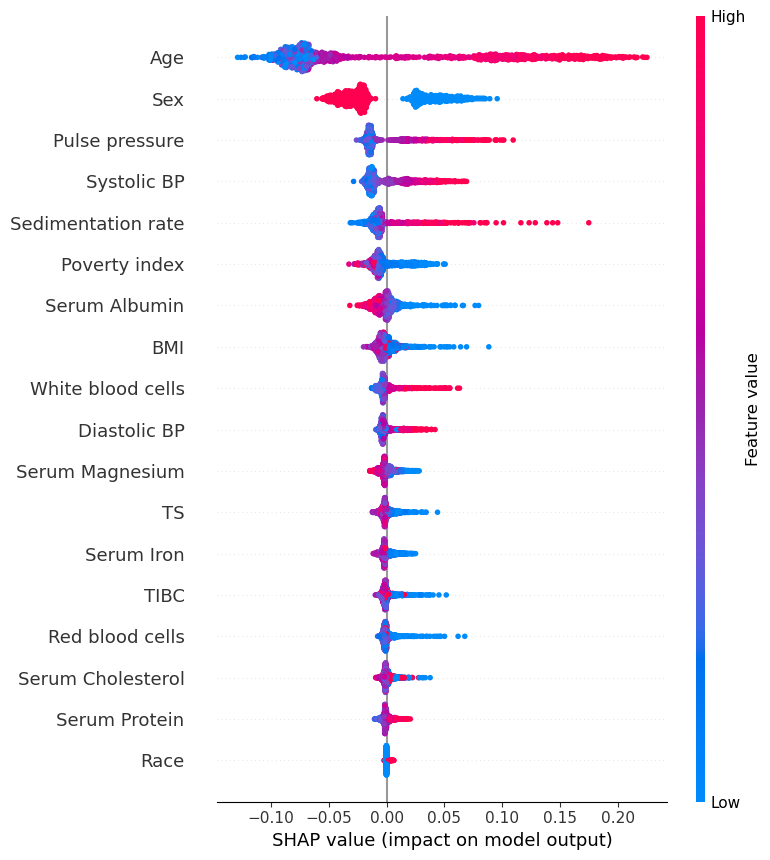

In [ ]:
shap.summary_plot(shap_values,X_test)

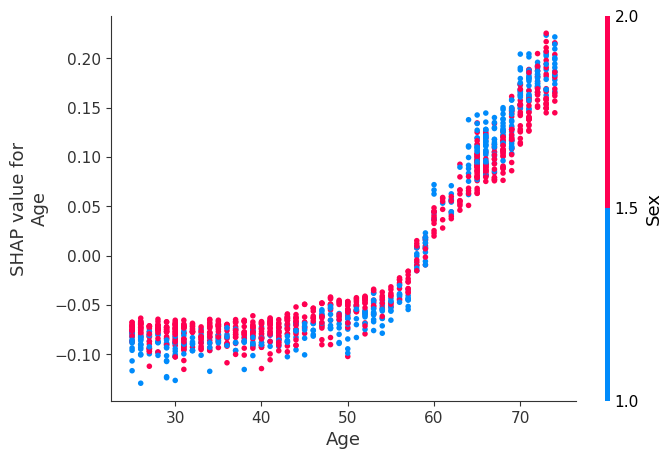

In [ ]:
shap.dependence_plot("Age",shap_values,X_test, interaction_index="Sex")